# GAN on Mnist Dataset (Task-1)

- Basic DCGAN implementation for MNIST like image generation
- Possible enhancement can be 1.better initialization of generator's and discriminator's layers 2. Using better Betas for Adam 3. More Epochs 4. Working on Generator for reducing its loss

In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import torch
from matplotlib import pyplot as plt

In [2]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [3]:
train_data=datasets.MNIST(root='/kaggle/temp/mnist_train', train=True, download=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]))

100%|██████████| 9912422/9912422 [00:00<00:00, 109253648.72it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44567952.11it/s]

Extracting /kaggle/temp/mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26862838.11it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24773119.33it/s]


Extracting /kaggle/temp/mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/mnist_train/MNIST/raw



In [4]:
batch_size=64

In [5]:
train_dataloader=DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [6]:
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.2))
    return nn.Sequential(*layers)

def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

Convblock is used to extract features from the input image and downsample it, typically used in discriminator to perform convolution and downsampling

tconvblock - This block is used to upsample the input noise vector and generate new images from it, typically used in the generator to perform transposed convolution and upsampling.

In [7]:
class Generator(nn.Module):
    def __init__(self,latent_dim, img_size):
        super().__init__()
        self.latent_dim=latent_dim  
        self.img_size=img_size
        self.init_size=self.img_size//4   #inirial size of the feature vector

        self.lin=nn.Linear(in_features=self.latent_dim,out_features=128*self.init_size*self.init_size )

        self.tconvblocks=nn.Sequential(tconvblock(128,64,4,2,1),tconvblock(64,32,4,2,1))

        self.convtanh=nn.Sequential(nn.Conv2d(32,1,3,1,1),nn.Tanh())


    def forward(self,x):
        x=self.lin(x)
        x=x.view(x.shape[0],128,self.init_size,self.init_size)
        x=self.tconvblocks(x)
        x=self.convtanh(x)

        return x

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super().__init__()

        self.img_size=img_size

        self.convblocks=nn.Sequential(convblock(1,16,4,2,1), convblock(16,32,4,2,1), convblock(32,64,4,2,1),convblock(64,128,4,2,1))

        self.out=nn.Sequential(nn.Linear(128*(self.img_size//(2**(len(self.convblocks)-1))),2))

    def forward(self,x):
        x=self.convblocks(x)
        x=x.view(x.shape[0],-1)
        pred=self.out(x)
        return pred

In [8]:
loss_fn=nn.CrossEntropyLoss().to(device)
n_epochs=5 #actually, you should run for more epochs, may be 200
lr=0.0002

generator=Generator(100,32).to(device)
discriminator=Discriminator(32).to(device)

gopt=optim.Adam(params=generator.parameters(),lr=lr)
dopt=optim.Adam(params=discriminator.parameters(),lr=lr)

In [9]:
def train_one_epoch(plt):
    for i,(imgs,_) in enumerate(train_dataloader):

        noise_vectors=torch.randn((imgs.shape[0],100)).to(device)

        zero_labels=torch.zeros((imgs.shape[0])).to(device).type(torch.int64)
        one_labels=torch.ones((imgs.shape[0])).to(device).type(torch.int64)

        fake_images=generator(noise_vectors)

        pred=discriminator(fake_images)

        gloss=loss_fn(pred,one_labels)

        gopt.zero_grad()
        gloss.backward()
        gopt.step()


        real_imgs=imgs.to(device)

        pred_on_real=discriminator(real_imgs)
        dloss_on_real=loss_fn(pred_on_real,one_labels)
        pred_on_fake=discriminator(fake_images.detach())
        dloss_on_fake=loss_fn(pred_on_fake,zero_labels)
        dloss=(dloss_on_real+dloss_on_fake)/2

        dopt.zero_grad()
        dloss.backward()
        dopt.step()

        if i%500 == 0:

            print("Batch No.:", i+1,"/",len(train_dataloader),":", "GLoss=",round(gloss.item(),4), "DLoss=",round(dloss.item(),4))
            for j in range(64):
                plt.subplot(8,8,j+1)
                plt.imshow(torch.permute(fake_images[j],(1,2,0)).detach().cpu(),interpolation='nearest', cmap='gray_r')

            plt.show()


Epoch 1 / 5 :
Batch No.: 1 / 938 : GLoss= 0.9537 DLoss= 0.6624


/tmp/ipykernel_24/555927718.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8,8,j+1)


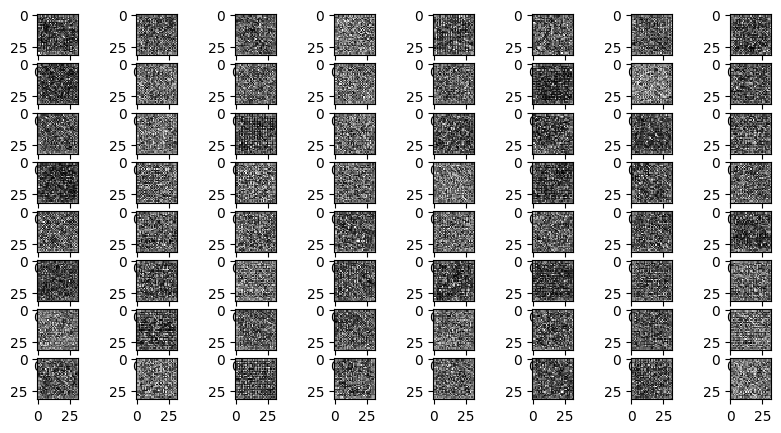

Batch No.: 501 / 938 : GLoss= 4.6079 DLoss= 0.0428


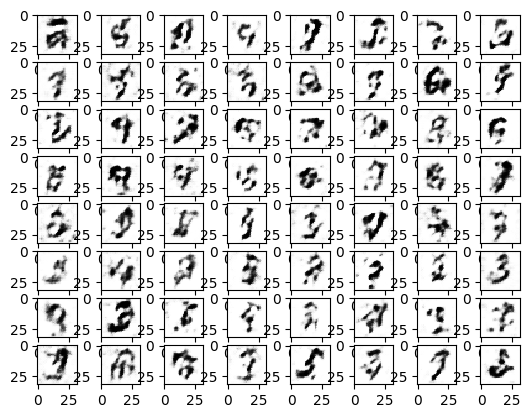

Epoch 2 / 5 :
Batch No.: 1 / 938 : GLoss= 4.9401 DLoss= 0.0227


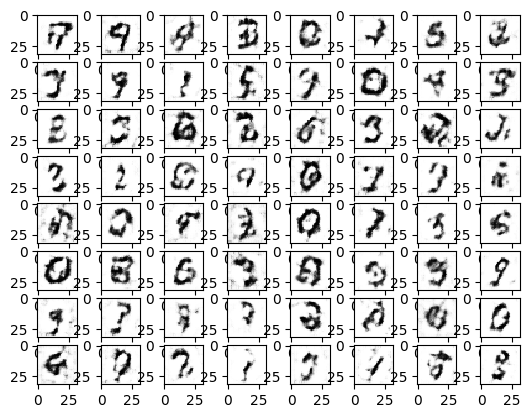

Batch No.: 501 / 938 : GLoss= 5.9539 DLoss= 0.1378


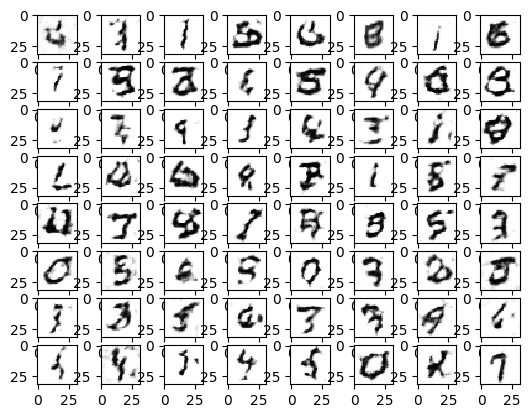

Epoch 3 / 5 :
Batch No.: 1 / 938 : GLoss= 6.3007 DLoss= 0.0205


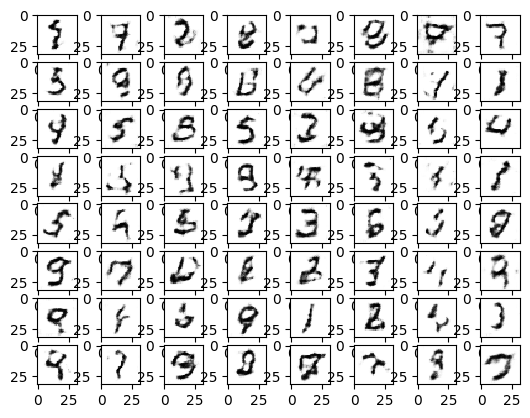

Batch No.: 501 / 938 : GLoss= 4.352 DLoss= 0.0409


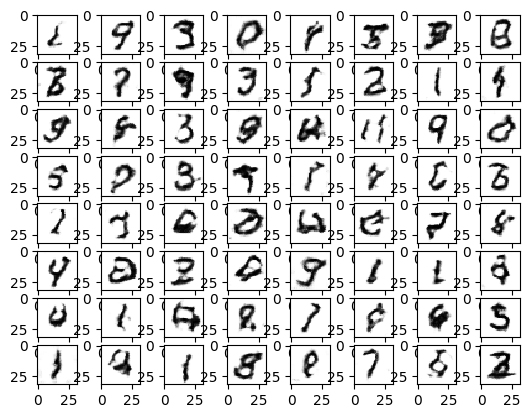

Epoch 4 / 5 :
Batch No.: 1 / 938 : GLoss= 6.1122 DLoss= 0.0053


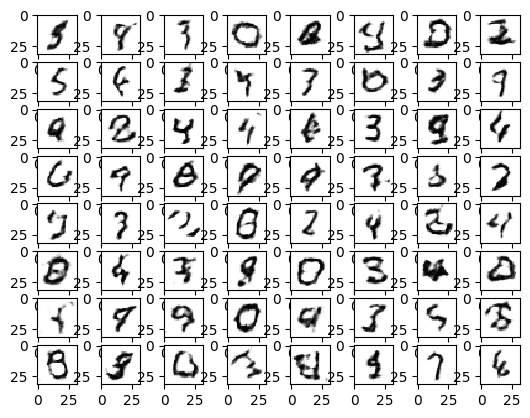

Batch No.: 501 / 938 : GLoss= 4.567 DLoss= 0.0112


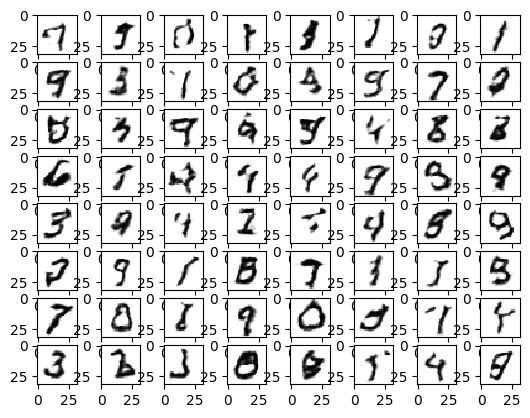

Epoch 5 / 5 :
Batch No.: 1 / 938 : GLoss= 4.6658 DLoss= 0.0199


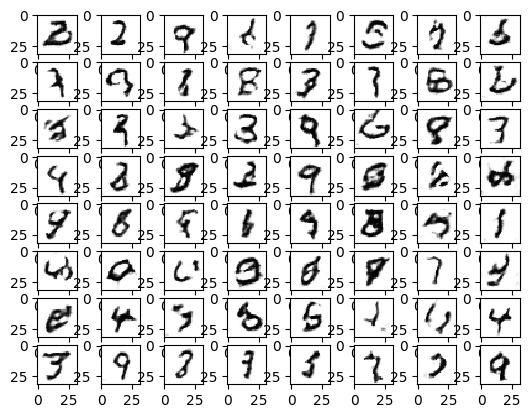

Batch No.: 501 / 938 : GLoss= 2.4817 DLoss= 0.0723


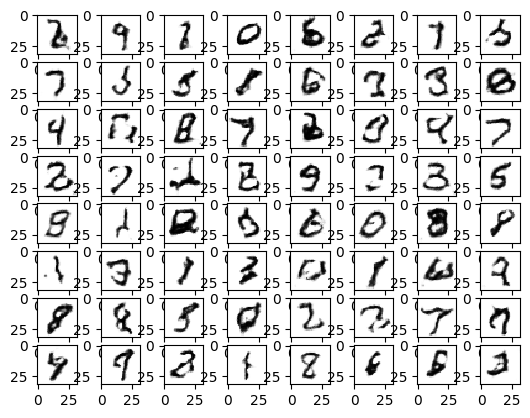

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generated Images")
for e in range(n_epochs):
    print("Epoch",e+1,"/",n_epochs,":")
    train_one_epoch(plt)

The code begins by importing necessary libraries such as PyTorch, including modules for neural networks, data loading, optimization, and visualization using Matplotlib. It loads the MNIST dataset using torchvision's datasets module and applies necessary transformations such as resizing, converting to tensors, and normalization.

Generator: Defines a neural network to generate fake images. It uses transpose convolutional layers to upsample the input noise vector.
Discriminator: Defines a neural network to discriminate between real and fake images. It uses convolutional layers for feature extraction.

It trains the GAN for a specified number of epochs.
In each epoch, it iterates over the training data loader.
For each batch:
Generates fake images using the generator.
Computes the discriminator's loss on both real and fake images.
Updates the generator and discriminator parameters using backpropagation and optimization.